# Prediction of expression modulation targets with FSEOF

Algorithms like Optgene can predict gene knockout targets, but another possibility for optimizing hemoglobin production is up- or downregulation of genes. A function for this is the Flux Scanning based on Enforced Objective Flux (FSEOF) from the Computer Aided Metabolic Engineering & Optimization (CAMEO) package (Cardoso et al. 2018). FSEOF searches for target genes for up- or down-regulation by first enforcing the flux of a desired reaction under the objective of maximizing biomass production (Choi et al 2010). The function then indentifies the metabolic fluxes that increased or decreased when the desired reaction was forced to increase (Choi et al 2010). 

### Running FSEOF and getting all regulation targets

Model and package imports:

In [1]:
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
from cameo import models
from cameo.visualization.plotting.with_plotly import PlotlyPlotter
import numpy as np
from cameo.strain_design.deterministic.flux_variability_based import FSEOF
import matplotlib.pyplot as plt

In [2]:
model = read_sbml_model('model_yeast8_rhb.xml')

First, the FSEOF analysis is defined and run. As specified in fseof.run, the target for optimization is here the "EX_rHb" reaction, which is the exchange reaction for hemoglobin. By default the flux of the target reaction is maximized to 90% of its theoretical maximum. Furthermore, the primary objective in the optimization is the model.objective by default (here, biomass).

In [3]:
fseof = FSEOF(model)

In [4]:
result = fseof.run(target=model.reactions.EX_rHb)

The results are saved in a dataframe:

In [5]:
df = result.data_frame

Below are shown the top and bottom hits of the FSEOF analysis. Each row is a different reaction that changed flux with the forced flux increase of hemoglobin exchange, and which should therefore be up- or down-regulated. Each column shows the fluxes observed for the given reaction, when EX_rHb is increased in steps until the specified 90% of theoretical maximum (column 10). The result shows that are there **196** targets. 

In [6]:
df

,1,2,3,4,5,6,7,8,9,10
PRMICI,0.115994,0.166209,0.216423,0.266638,0.316665,0.366584,0.416503,0.466423,0.516174,0.565714
AATA,0.324257,0.364560,0.404863,0.445166,0.484658,0.523687,0.562715,0.601743,0.640048,0.677437
DDPAm,0.402470,0.441860,0.481249,0.520639,0.558992,0.596752,0.634512,0.672271,0.709106,0.744770
IPPMIb,-0.374670,-0.455266,-0.535861,-0.616457,-0.696214,-0.775489,-0.854765,-0.934041,-1.012567,-1.090145
IPPS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.012567,1.090145
...,...,...,...,...,...,...,...,...,...,...
FRD2m,0.000000,0.000000,0.000000,0.000000,0.182600,0.238012,0.293424,0.348837,0.404485,0.460432
PYRTRAINPROSYM,-3.497384,-4.400731,-5.304077,-6.207424,-6.855308,-7.786479,-8.717649,-9.648820,-10.574494,-11.493211
SHSL2,0.014957,0.023201,0.031445,0.039689,0.047914,0.056128,0.064342,0.072556,0.080752,0.068317
rHb,0.001470,0.002940,0.004410,0.005880,0.007350,0.008820,0.010290,0.011760,0.013231,0.014701


### Identifying reactions with the largest change in flux 

To get a better overview of the results, two columns are added to the dataframe: Change and Percent Change. The Change describes the change (positive or negative) in flux from the first calculated flux to the last (at 90% of theoretical max for desired product). The Percent Change describes the change in percentage relative to the beginning value, as calculated by:

$\frac{flux_{end} - flux_{start}}{flux_{start}} * 100$

If the flux of a reaction is zero in the beginning, the Percent Change is defined as NaN.

In [7]:
change = []
for i in range(len(df)):
    change.append(df.iloc[i,9]-df.iloc[i,0])
    
df['Change']=change

In [8]:
percent_change = []
for i in range(len(df)):
    if df.iloc[i,0] != 0:
        percent_change.append(((df.iloc[i,9]-df.iloc[i,0])/df.iloc[i,0])*100)
    else:
        percent_change.append(np.nan)

df['Percent_change']=percent_change

The reactions can then be sorted based on Percent Change to see the reactions with the highest relative change and thereby most interesting targets. Below are shown the top 20 targets with the highest expression modulation:

In [9]:
df_sorted = df.reindex(df.Percent_change.abs().sort_values(ascending=False).index) 
df_sorted.head(10)

,1,2,3,4,5,6,7,8,9,10,Change,Percent_change
GLYSTASYN,0.285365,0.258563,0.231761,0.204959,0.698258,2.081123,3.463987,4.846851,5.232680,6.490743,6.205378,2174.540676
NAt3_1,-0.003135,-0.002840,-0.002546,-0.002251,-0.250010,-0.210233,-0.170456,-0.130679,-0.089781,-0.047462,-0.044327,1413.939394
ME2m,0.235539,0.248796,0.262052,0.275309,0.287931,0.300190,0.312449,0.324708,1.912791,2.673339,2.437800,1034.987836
TKT2,0.116358,0.332468,0.548578,0.764688,0.969673,1.168277,1.366881,1.565486,1.236362,1.237243,1.120885,963.307207
rHb,0.001470,0.002940,0.004410,0.005880,0.007350,0.008820,0.010290,0.011760,0.013231,0.014701,0.013231,900.068027
EX_rHb,0.001470,0.002940,0.004410,0.005880,0.007350,0.008820,0.010290,0.011760,0.013231,0.014701,0.013231,900.000000
PPBNGS,0.023524,0.047045,0.070565,0.094086,0.117607,0.141127,0.164648,0.188169,0.211689,0.235210,0.211686,899.872471
5AOPtm,-0.047048,-0.094090,-0.141131,-0.188172,-0.235214,-0.282255,-0.329296,-0.376337,-0.423379,-0.470420,-0.423372,899.872471
ALASm,0.047048,0.094090,0.141131,0.188172,0.235214,0.282255,0.329296,0.376337,0.423379,0.470420,0.423372,899.872471
UPPDC1,0.005881,0.011761,0.017641,0.023522,0.029402,0.035282,0.041162,0.047042,0.052922,0.058802,0.052921,899.863969


To get more insight to the expression modulation targets, we can count the number of up- and down-regulations targets. Note that a negative flux, which becomes more negative is an upregulation (the minus is due to the definition of the reaction direction). On the other hand, when a negative flux which becomes more positive, it is a downregulation.

In [10]:
upreg_counter = 0
downreg_counter = 0
for i in range(0,195):
    if df_sorted.iloc[i,11] > 0:
        upreg_counter = upreg_counter + 1
    elif df_sorted.iloc[i,11] < 0:
        downreg_counter = downreg_counter + 1
    elif np.isnan(df_sorted.iloc[i,11]):         # the reactions which had 0 flux in the beginning is counted by the "Change" column instead
        if df_sorted.iloc[i,10] > 0:
            upreg_counter = upreg_counter + 1
        elif df_sorted.iloc[i,10] < 0:
            downreg_counter = downreg_counter + 1
            
print("There are",upreg_counter,"up-regulation targets and",downreg_counter,"down-regulation tagets.")

There are 142 up-regulation targets and 53 down-regulation tagets.


We can visualize their degree of up- or down-regulation in a plot:

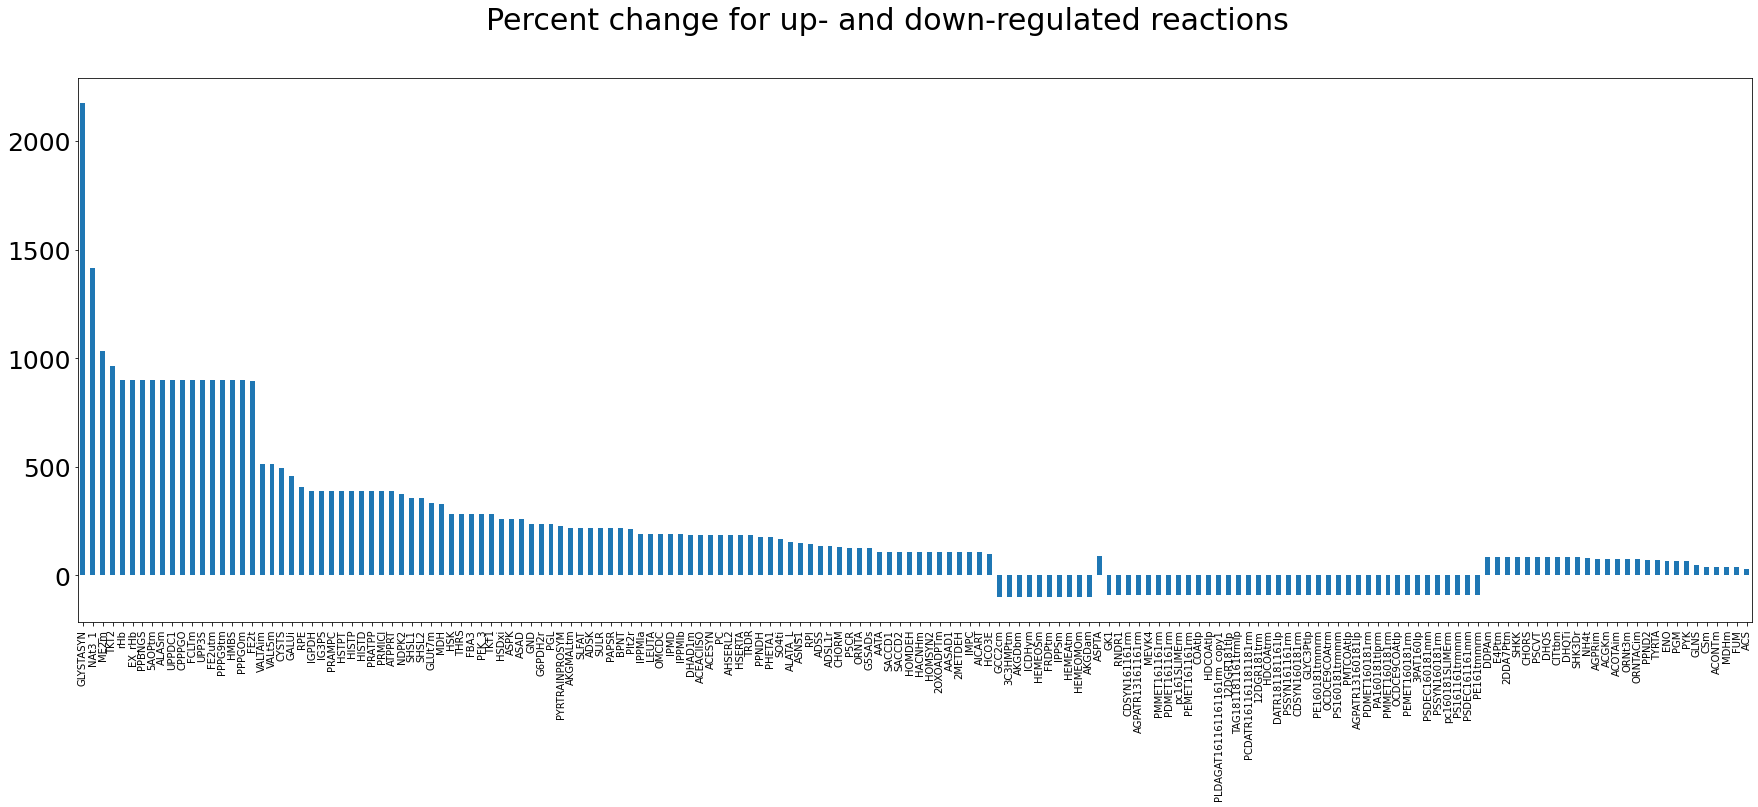

In [23]:
plotdata = df_sorted.iloc[0:168,11]
fig = plotdata.plot(kind='bar')
plt.rcParams["figure.figsize"] = [30, 10]
fig.tick_params(axis='y', labelsize=25)
plt.suptitle("Percent change for up- and down-regulated reactions", fontsize=30)
plt.show()

### Investigation of top 10 targets with visualization

The reaction name for the top 10 reactions with the highest relative change is given below:

In [12]:
for i in range(10):
    print(model.reactions.get_by_id(df_sorted.index.values[i]).id, model.reactions.get_by_id(df_sorted.index.values[i]).name)

GLYSTASYN glycogen (starch) synthase
NAt3_1 sodium proton antiporter
ME2m malic enzyme (NADP)
TKT2 transketolase 2
rHb 
EX_rHb 
PPBNGS porphobilinogen synthase
5AOPtm 5-aminolevulinate transport
ALASm 5-aminolevulinate synthase
UPPDC1 uroporphyrinogen decarboxylase (uroporphyrinogen III)


From the names above, it can be seen that target 5-10 are part of the heme synthesis pathway as well as the hemoglobin synthesis and exchange. Rationally, it makes sense that these are upregulated to generate a high production flux of hemoglobin. However, for target 1-4 the rationale is not immediately obvious, but it could potentially be explained with higher precursor availability. Addtionally, it can be seen from Percent Change columns that all targets in top 10 have a positive percent change and therefore are *up*-regulated.

To get a better overview of the upregulated targets involved in the hemoglobin synthesis, they can be visualized with Escher (King et al. 2015). 

In [13]:
import escher

To visualize the top 10 upregulated pathways, a dictionary is created which contains their reaction id as well as their flux when the target reaction is at 90% of max productivity (column 10).

In [14]:
Reg_fluxes = dict(zip(df_sorted.index.values[0:10], df_sorted.iloc[0:10,10]))

In [15]:
escher.Builder(model = model,
    map_json='Yeast8_hemoglobin_synthesis2.json',
               reaction_data=Reg_fluxes)

Builder(reaction_data={'GLYSTASYN': 6.2053780000000005, 'NAt3_1': -0.044327, 'ME2m': 2.4377999999999997, 'TKT2…

### Simulations of model with up- and down-regulations

These simulations are performed to get an idea of whether a few targets can be regulated to get high hemoglobin production or it is necessary to upregulate all 196 identified targets. The regulations are simulated by adjusting the lower and upper bound of the target reaction to the flux identified when the target reaction is at 90% of max productivity (column 10). This forces the reaction to have the given flux.

Below are calculated rate of hemoglobin production, growth rate and yield of hemoglobin on glucose for all strain designs.

**Strain with no expression modulation - optimized for growth:**

In [16]:
with model:
    model.optimize()
    print("Rate of hemoglobin production:", model.reactions.EX_rHb.flux,"mmol/(gDW*h)")
    print("Growth rate:", model.reactions.GROWTH.flux,"h^-1")
    print("Yield for hemoglobin on glucose", model.reactions.EX_rHb.flux / (-1*model.reactions.EX_glc__D_e.flux),"mmol-hemoglobin / mmol-glucose")

Rate of hemoglobin production: 0.0 mmol/(gDW*h)
Growth rate: 0.8637367930478769 h^-1
Yield for hemoglobin on glucose 0.0 mmol-hemoglobin / mmol-glucose


**Theoretical max for cell with hemoglobin as objective function:**

In [17]:
with model:
    model.objective = model.reactions.EX_rHb
    model.optimize()
    print("Rate of hemoglobin production:", model.reactions.EX_rHb.flux,"mmol/(gDW*h)")
    print("Growth rate:", model.reactions.GROWTH.flux,"h^-1")
    print("Yield for hemoglobin on glucose", model.reactions.EX_rHb.flux / (-1*model.reactions.EX_glc__D_e.flux),"mmol-hemoglobin / mmol-glucose")

Rate of hemoglobin production: 0.016333900695119242 mmol/(gDW*h)
Growth rate: 0.0 h^-1
Yield for hemoglobin on glucose 0.0016333900695119242 mmol-hemoglobin / mmol-glucose


**Upregulation of top 3 targets**

Here the top 3 targets were upregulated. We see no effect on hemoglobin production, when comparing to the strain optimized for growth with no regulation. However, the growth has fallen to 96% of its theoretical max. 

In [18]:
with model:
    for i in range(0,3):
        model.reactions.get_by_id(df_sorted.index.values[i]).bounds = df_sorted.iloc[i,10], df_sorted.iloc[i,10]
    model.optimize()
    print("Rate of hemoglobin production:", model.reactions.EX_rHb.flux,"mmol/(gDW*h)")
    print("Growth rate:", model.reactions.GROWTH.flux,"h^-1")
    print("Yield for hemoglobin on glucose", model.reactions.EX_rHb.flux / (-1*model.reactions.EX_glc__D_e.flux),"mmol-hemoglobin / mmol-glucose")

Rate of hemoglobin production: 0.0 mmol/(gDW*h)
Growth rate: 0.83405096192123 h^-1
Yield for hemoglobin on glucose 0.0 mmol-hemoglobin / mmol-glucose


**Upregulation of top 7 targets, except rHb and EX_rHb**

Following the top3 targets, a trial and error approach was performed where more and more targets were included in the upregulation together. However, during this, the rHb and EX_rHb reactionens were *not* upregulated because that might have created an artefact, which does not produce useful results. In the trial and error it was found that especially the inclusion of the reaction PPBNGS gave a big increase difference in the hemoglobin production as seen below:

In [19]:
with model:
    for i in [x for x in range(0,7) if x !=4 and x!=5]:
        model.reactions.get_by_id(df_sorted.index.values[i]).bounds = df_sorted.iloc[i,10], df_sorted.iloc[i,10]
    model.optimize()
    print("Rate of hemoglobin production:", model.reactions.EX_rHb.flux,"mmol/(gDW*h)")
    print("Growth rate:", model.reactions.GROWTH.flux,"h^-1")
    print("Yield for hemoglobin on glucose", model.reactions.EX_rHb.flux / (-1*model.reactions.EX_glc__D_e.flux),"mmol-hemoglobin / mmol-glucose")

Rate of hemoglobin production: 0.01323033140615089 mmol/(gDW*h)
Growth rate: 0.17437539688295467 h^-1
Yield for hemoglobin on glucose 0.001323033140615089 mmol-hemoglobin / mmol-glucose


**Upregulation of PPBNGS alone**

Because of the large effect of including PPBNGS in the upregulation, the effect of *only* upregulating PPBNGS was investigated. From the optimization below it can be seen this upregulation leads to a hemoglobin production and yield, which is 81% of the theoretical max, but a decrease in growth rate, so it is only 21% of max theoretical growth rate. 

In [20]:
with model:
    model.reactions.get_by_id('PPBNGS').bounds = df_sorted.iloc[6,10], df_sorted.iloc[6,10]
    model.optimize()
    print("Rate of hemoglobin production:", model.reactions.EX_rHb.flux,"mmol/(gDW*h)")
    print("Growth rate:", model.reactions.GROWTH.flux,"h^-1")
    print("Yield for hemoglobin on glucose", model.reactions.EX_rHb.flux / (-1*model.reactions.EX_glc__D_e.flux),"mmol-hemoglobin / mmol-glucose")

Rate of hemoglobin production: 0.013230330963362244 mmol/(gDW*h)
Growth rate: 0.1761465514674257 h^-1
Yield for hemoglobin on glucose 0.0013230330963362245 mmol-hemoglobin / mmol-glucose


To investigate the effect of PPBNGS upregulation on the trade-off between hemoglobin production and growth, the bounds of PPBNGS were set to all the different increasing fluxes obtained in the FSEOF analysis. 

In [21]:
x_growth = np.zeros(10)
y_production = np.zeros(10)
with model:
    for i in range (0,10):
        model.reactions.get_by_id('PPBNGS').bounds = df_sorted.iloc[6,i], df_sorted.iloc[6,i]
        model.optimize()
        x_growth[i] = model.reactions.GROWTH.flux
        y_production[i] = model.reactions.EX_rHb.flux

The result of sequentially increasing the bounds of PPBNGS (equal to overexpression) can be seen in the figure below. Here it can be seen that there is a clear trade-off between hemoglobin production and growth rate. High overexpression (left of figure) gives high hemoglobin production and low growth, and decreasing overexpression gives lower production and higher growth.

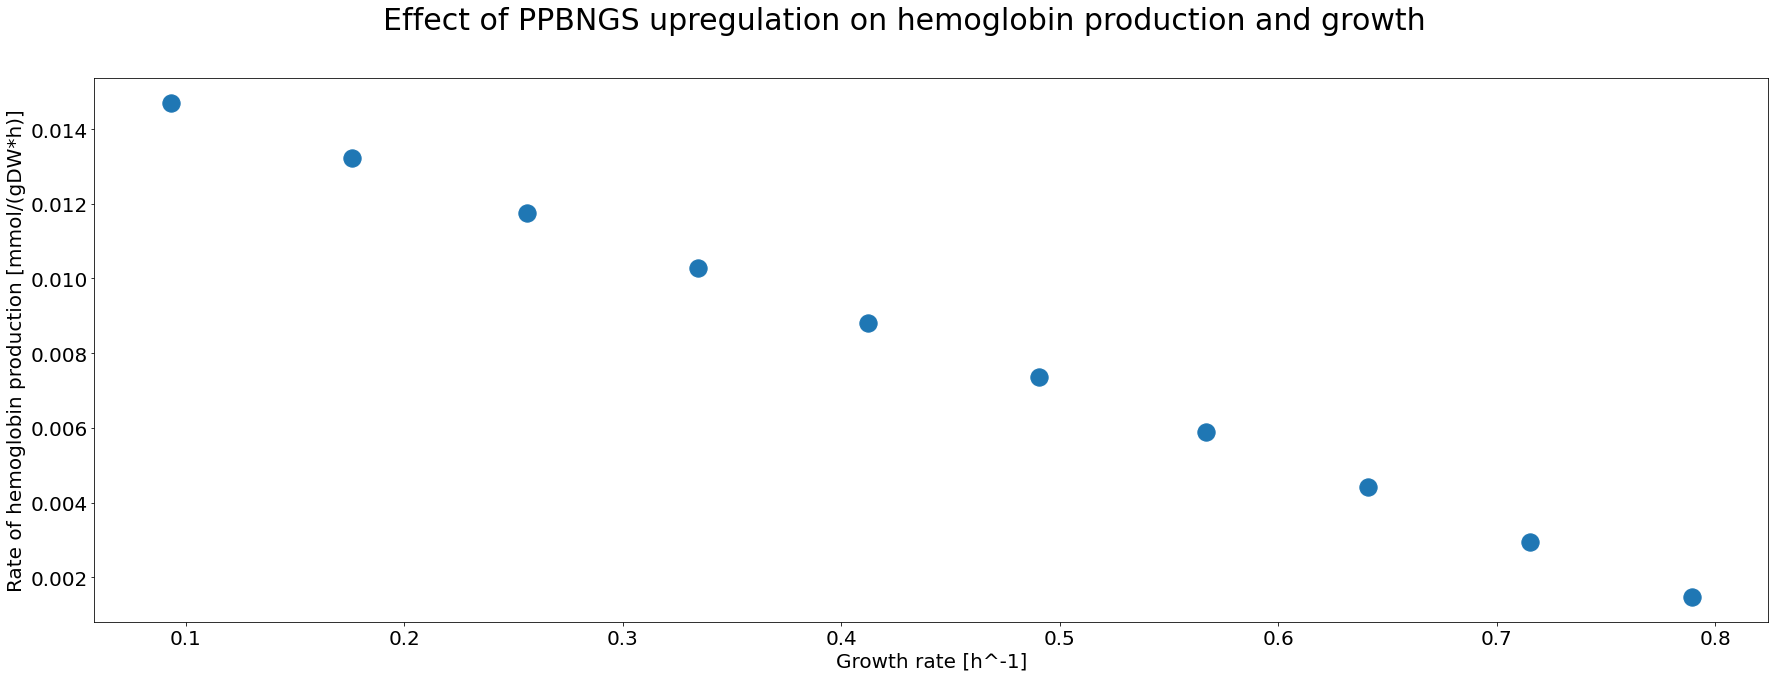

In [22]:
plt.scatter(x_growth, y_production, s=300)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.xlabel('Growth rate [h^-1]',fontsize=20)
plt.ylabel('Rate of hemoglobin production [mmol/(gDW*h)]', fontsize=20)
plt.suptitle("Effect of PPBNGS upregulation on hemoglobin production and growth", fontsize=30)
plt.show()

### Sources:

Cardoso, J. G. R., Jensen, K., Lieven, C., Hansen, A. S. L., Galkina, S., Beber, M., Özdemir, E., Herrgård, M. J., Redestig, H., & Sonnenschein, N. (2018). Cameo: A Python Library for Computer Aided Metabolic Engineering and Optimization of Cell Factories. ACS Synthetic Biology, 7(4), 1163–1166. https://doi.org/10.1021/acssynbio.7b00423  

Choi, H. S., Lee, S. Y., Kim, T. Y., & Woo, H. M. (2010). In silico identification of gene amplification targets for improvement of lycopene production. Applied and Environmental Microbiology, 76(10), 3097–3105. https://doi.org/10.1128/AEM.00115-10

King, Z. A., Dräger, A., Ebrahim, A., Sonnenschein, N., Lewis, N. E., & Palsson, B. O. (2015). Escher: A Web Application for Building, Sharing, and Embedding Data-Rich Visualizations of Biological Pathways. PLoS Computational Biology, 11(8), 1–13. https://doi.org/10.1371/journal.pcbi.1004321